In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-03-12 12:50:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-12 12:50:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-12 12:50:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
# !unzip glove*.zip

Archive:  glove.6B.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of glove.6B.zip or
        glove.6B.zip.zip, and cannot find glove.6B.zip.ZIP, period.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# import shutil
# shutil.move('glove.6B.100d.txt', '/content/drive/My Drive/glove.6B.100d.txt')

In [8]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

def loadData(filePath):
    with open(filePath, "r") as f:
        data = json.load(f)
    texts = [data[str(id)]["text"] for id in range(1, len(data)+1)]
    labels = [data[str(id)]["labels"] for id in range(1, len(data)+1)]
    return texts, labels

def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r', encoding='utf-8')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

def applyEmbedding(texts, glove_model):
    finList = []
    for text in texts:
        tempList = []
        for word in text.split():
            if word in glove_model:
                tempList.append(glove_model[word])
            else:
                tempList.append(np.random.rand(len(next(iter(glove_model.values())))))
        finList.append(tempList)
    return finList

# trainTexts, trainLabels = loadData("/content/train_processed_t2.json")
# validationTexts, validationLabels = loadData("/content/validation_processed_t2.json")
# testTexts, testLabels = loadData("/content/test_processed_t2.json")



trainTexts, trainLabels = loadData("/content/drive/MyDrive/NLP_ass2/train_processed_t2.json")
validationTexts, validationLabels = loadData("/content/drive/MyDrive/NLP_ass2/validation_processed_t2.json")
testTexts, testLabels = loadData("/content/drive/MyDrive/NLP_ass2/test_processed_t2.json")

glove_model = loadGloveModel("/content/drive/MyDrive/glove.6B.100d.txt")

embedded_trainTexts = applyEmbedding(trainTexts, glove_model)
embedded_validationTexts = applyEmbedding(validationTexts, glove_model)
embedded_testTexts = applyEmbedding(testTexts, glove_model)



Loading Glove Model
Done. 400000  words loaded!


In [9]:
class CustomDataset(Dataset):
    def __init__(self, embedded_data, labels):
        self.embedded_data = embedded_data
        self.labels = labels
        self.max_length=469

    def __len__(self):
        return len(self.embedded_data)

    def __getitem__(self, idx):
        embedded_sequence = self.embedded_data[idx]
        labels = self.labels[idx]

        # Pad sequences to the maximum length in the batch

        # print(max_length)
        lent=len(labels)
        padded_sequence = []
        padded_labels=[]
        if(lent<=max_length):
          padded_sequence = embedded_sequence + [[0] * 100 for _ in range(self.max_length - lent)]
          padded_labels=labels+[-100]*(self.max_length - lent)


        # padded_sequence = []
        # for seq in embedded_sequence:
        #     if len(seq) < max_length:
        #         padded_sequence.append(seq + [0] * (max_length - len(seq)))

        #     else:
        #         padded_sequence.append(seq)
        #         print(seq.shape)

        return torch.tensor(padded_sequence).float(), torch.tensor(padded_labels).float()

max_length=469


trainDataset = CustomDataset(embedded_trainTexts, trainLabels)
validationDataset = CustomDataset(embedded_validationTexts, validationLabels)
testDataset = CustomDataset(embedded_testTexts, testLabels)
print(trainDataset)
trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True)
validationLoader = DataLoader(validationDataset, batch_size=32, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=32, shuffle=False)


In [10]:
for sent in range(len(trainLabels)):
  for label in range(len(trainLabels[sent])):
    if trainLabels[sent][label]=="B":
      trainLabels[sent][label] = 0
    elif trainLabels[sent][label]=="I":
      trainLabels[sent][label] = 1
    elif trainLabels[sent][label]=="O":
      trainLabels[sent][label] = 2

for sent in range(len(validationLabels)):
  for label in range(len(validationLabels[sent])):
    if validationLabels[sent][label]=="B":
      validationLabels[sent][label] = 0
    elif validationLabels[sent][label]=="I":
      validationLabels[sent][label] = 1
    elif validationLabels[sent][label]=="O":
      validationLabels[sent][label] = 2

for sent in range(len(testLabels)):
  for label in range(len(testLabels[sent])):
    if testLabels[sent][label]=="B":
      testLabels[sent][label] = 0
    elif testLabels[sent][label]=="I":
      testLabels[sent][label] = 1
    elif testLabels[sent][label]=="O":
      testLabels[sent][label] = 2


embedded_trainTensor = []
for senVect in embedded_trainTexts:
  embedded_trainTensor.append(torch.tensor(senVect))
embedded_validationTensor = []
for senVect in embedded_validationTexts:
  embedded_validationTensor.append(torch.tensor(senVect))
embedded_testTensor = []
for senVect in embedded_testTexts:
  embedded_testTensor.append(torch.tensor(senVect))
label_trainTensor = []
for label in trainLabels:
  print(label)
  break
for label in trainLabels:
  label_trainTensor.append(torch.tensor(label))
label_validationTensor = []
for label in validationLabels:
  label_validationTensor.append(torch.tensor(label))
label_testTensor = []
for label in testLabels:
  label_testTensor.append(torch.tensor(label))

<ipython-input-10-9a7827821b32>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  embedded_trainTensor.append(torch.tensor(senVect))


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2]


In [11]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from sklearn.metrics import f1_score, accuracy_score

# class VanillaGRU(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(VanillaGRU, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         out, _ = self.gru(x)
#         # out = self.fc(out[:, -1, :])
#         out = self.fc(out)
#         return out


#     def custom_loss(self, predicted_probs, target_labels):
#         """
#         Custom loss function that computes the cross-entropy loss
#         given predicted probabilities and target labels.
#         """
#         # Convert target labels to one-hot encoding
#         losses=0
#         # new_labels=[]
#         # prob_label=[]
#         for k in range(len(target_labels.tolist())):
#           i=target_labels[k]
#           j=predicted_probs[k]
#           a=i.tolist().index(-100)
#           # print(a)
#           b=torch.tensor(i.tolist()[:a],dtype=torch.long)
#           # print(b)
#           d=torch.tensor(j.tolist()[:a])
#           # print(b)
#           # print(d)

#           loss = F.cross_entropy(d, b)
#           losses+=loss


#         # for i,j in (target_labels,predicted_probs):
#         #   a=i.tolist().index(-100)
#         #   # print(a)
#         #   b=i.tolist()[:a]
#         #   # print(b)
#         #   d=j.tolist()[:a,]
#         #   loss = F.cross_entropy(d, b)
#         #   losses+=loss
#           # new_labels.append(b)


#         # target_one_hot = torch.nn.functional.one_hot(target_labels.to(torch.int64), num_classes=self.fc.out_features)
#         # # target_one_hot = F.one_hot(target_labels, num_classes=self.fc.out_features)

#         # # Compute cross-entropy loss
#         # # target_one_hot = torch.nn.functional.one_hot(target_labels.to(torch.int64), num_classes=self.fc.out_features)

#         # loss = F.binary_cross_entropy_with_logits(predicted_probs, target_one_hot.float())
#         return losses



# def macro_f1_score(predictions, labels):
#     predictions = predictions.argmax(dim=1).cpu().numpy()
#     labels = labels.cpu().numpy()
#     return f1_score(labels, predictions, average='macro')

# def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs):
#     train_loss = []
#     val_loss = []
#     train_f1_score = []
#     val_f1_score = []
#     va=0
#     for epoch in range(num_epochs):
#         print(epoch)
#         model.train()
#         cur_train_loss = 0.0
#         cur_train_predictions = []
#         cur_train_labels = []

#         for seq, label in train_loader:
#             optimizer.zero_grad()
#             outputs = model(seq)

#             # print(va)
#             # va=va+1
#             # print(outputs.size())
#             # print(label.size())
#             loss = model.custom_loss(outputs, label)
#             loss.requires_grad = True
#             loss.backward()
#             optimizer.step()
#             cur_train_loss += loss.item()

#             cur_train_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
#             cur_train_labels.extend(label.argmax(dim=1).cpu().numpy())

#         train_loss.append(cur_train_loss / len(train_loader))
#         train_f1_score.append(macro_f1_score(torch.tensor(cur_train_predictions), torch.tensor(cur_train_labels)))
#         model.eval()

#         cur_val_loss = 0.0
#         cur_val_predictions = []
#         cur_val_labels = []

#         with torch.no_grad():
#             for seq, label in validation_loader:
#                 outputs = model(seq)
#                 # print(outputs.size())
#                 # print(label.size())
#                 loss = model.custom_loss(outputs, label)
#                 cur_val_loss += loss.item()
#                 cur_val_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
#                 cur_val_labels.extend(label.argmax(dim=1).cpu().numpy())

#         val_loss.append(cur_val_loss / len(validation_loader))
#         val_f1_score.append(macro_f1_score(torch.tensor(cur_val_predictions), torch.tensor(cur_val_labels)))

#     return train_loss, train_f1_score, val_loss, val_f1_score




# input_dim = 100  # Based on size of GloVe embedding
# hidden_dim = 128  # Randomly chosen
# output_dim = 3  # No of labels
# num_epochs = 200
# learning_rate = 0.01

# model = VanillaGRU(input_dim, hidden_dim, output_dim)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# final_train_loss, final_train_f1_score, final_val_loss, final_val_f1_score = train_model(model, trainLoader, validationLoader, criterion, optimizer, num_epochs)


In [12]:
torch.set_grad_enabled(True)

In [13]:
def evaluate_model(model, test_loader):
    model.eval()
    final_predictions = []
    final_labels = []

    with torch.no_grad():
        for seq, label in test_loader:

          outputs = model(seq)
          for k in range(len(label.tolist())):
            i=label[k]
            j=outputs[k]
            a=i.tolist().index(-100)
            # print(a)
            b=i.tolist()[:a]
            # print(b)
            d=torch.tensor(j.tolist()[:a])
            predicted_labels = (torch.argmax(d, dim=1)).tolist()
            # print(predicted_labels)
            # print(b)
            final_predictions=final_predictions+predicted_labels
            final_labels=final_labels+b
            # print(b)
            # print(d)


    print(final_predictions)
    print(final_labels)

    accuracy = accuracy_score(final_labels, final_predictions)
    macro_f1 = f1_score(final_labels, final_predictions, average='macro')
    print(accuracy,macro_f1)
    return accuracy, macro_f1



In [14]:
import torch
import torch
import torch
import torch
import torch
import torch
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score

class VanillaGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(VanillaGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        # out = self.fc(out[:, -1, :])
        out = self.fc(out)
        return out

    def custom_loss(self, predicted_probs, target_labels):
        """
        Custom loss function that computes the cross-entropy loss
        given predicted probabilities and target labels.
        """
        # Apply masking to handle variable-length sequences with padding
        mask = (target_labels != -100).float()

        # Compute cross-entropy loss
        loss = F.cross_entropy(predicted_probs.permute(0, 2, 1), target_labels.to(torch.long), reduction='none')
        # Apply masking to ignore padded elements
        masked_loss = (loss * mask).sum(dim=1).mean()

        return masked_loss

    # def custom_loss(self, predicted_probs, target_labels):
    #     """
    #     Custom loss function that computes the cross-entropy loss
    #     given predicted probabilities and target labels.
    #     """
    #     # Convert target labels to one-hot encoding
    #     losses=0
    #     # new_labels=[]
    #     # prob_label=[]
    #     for k in range(len(target_labels.tolist())):
    #       i=target_labels[k]
    #       j=predicted_probs[k]
    #       a=i.tolist().index(-100)
    #       # print(a)
    #       b=torch.tensor(i.tolist()[:a],dtype=torch.long)
    #       # print(b)
    #       d=torch.tensor(j.tolist()[:a])
    #       # print(b)
    #       # print(d)

    #       loss = F.cross_entropy(d, b)
    #       losses+=loss



    #     return losses



def macro_f1_score(predictions, labels):
    predictions = predictions.argmax(dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    return f1_score(labels, predictions, average='macro')

def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs):
    train_loss = []
    val_loss = []
    train_f1_score = []
    val_f1_score = []
    va=0
    model.train()
    for epoch in range(num_epochs):
        print(epoch)

        cur_train_loss = 0.0
        cur_train_predictions = []
        cur_train_labels = []

        for seq, label in train_loader:
            optimizer.zero_grad()
            outputs = model(seq)

            # print(va)
            # va=va+1
            # print(outputs.size())
            # print(label.size())
            loss = model.custom_loss(outputs, label)
            # loss.requires_grad = True
            loss.backward()
            optimizer.step()
            cur_train_loss += loss.item()

            cur_train_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
            cur_train_labels.extend(label.argmax(dim=1).cpu().numpy())

        train_loss.append(cur_train_loss / len(train_loader))
        acc,f1=evaluate_model(model,train_loader)
        train_f1_score.append(f1)

        model.eval()
        print(cur_train_loss)
        cur_val_loss = 0.0
        cur_val_predictions = []
        cur_val_labels = []

        with torch.no_grad():
            for seq, label in validation_loader:
                outputs = model(seq)
                # print(outputs.size())
                # print(label.size())
                loss = model.custom_loss(outputs, label)
                cur_val_loss += loss.item()
                cur_val_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
                cur_val_labels.extend(label.argmax(dim=1).cpu().numpy())

        val_loss.append(cur_val_loss / len(validation_loader))
        acc,f1=evaluate_model(model,validation_loader)
        val_f1_score.append(f1)

    return train_loss, train_f1_score, val_loss, val_f1_score




input_dim = 100  # Based on size of GloVe embedding
hidden_dim = 128  # Randomly chosen
output_dim = 3  # No of labels
num_epochs = 20
learning_rate = 0.01

model = VanillaGRU(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

final_train_loss, final_train_f1_score, final_val_loss, final_val_f1_score = train_model(model, trainLoader, validationLoader, criterion, optimizer, num_epochs)



Output hidden; open in https://colab.research.google.com to view.

In [15]:
import matplotlib.pyplot as plt

def plotloss(losses,name):
  epochs = range(1, len(losses) + 1)

  plt.plot(epochs, losses, marker='o', color='b', linestyle='-')


  plt.xlabel('Epoch Number')
  plt.ylabel(f'{name} Loss')
  plt.title(f'{name} Loss vs. Epoch Number')


  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [16]:
def plot_f1(f1,name):
  epochs = range(1, len(f1) + 1)

  plt.plot(epochs, f1, marker='o', color='b', linestyle='-')


  plt.xlabel('Epoch Number')
  plt.ylabel(f'{name} F1')
  plt.title(f'{name} F1 vs. Epoch Number')


  plt.grid(True)
  plt.tight_layout()
  plt.show()

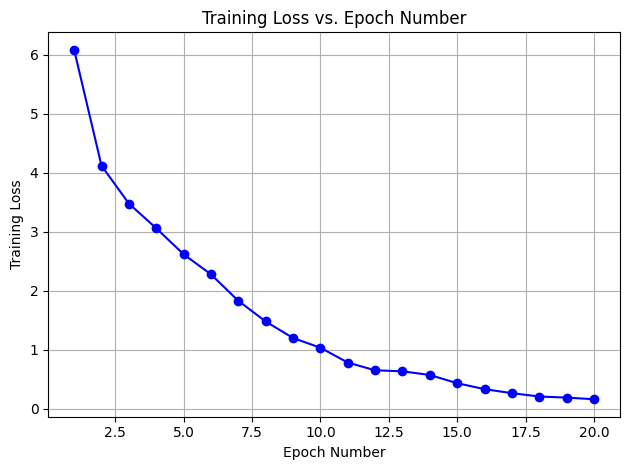

In [17]:
plotloss(final_train_loss,"Training")

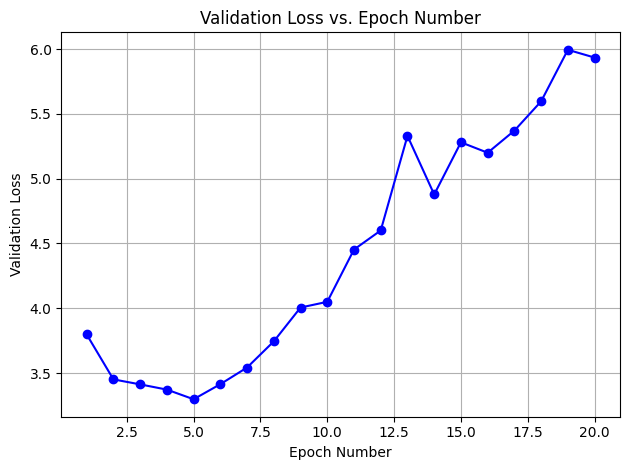

In [19]:
plotloss(final_val_loss,"Validation")

In [20]:
print("validation f1 score",final_train_f1_score)

validation f1 score [0.6477807590145244, 0.7432829039550587, 0.7699343554909852, 0.8362121370006189, 0.8362931123729673, 0.8985549847626011, 0.9230311595434144, 0.9389644174254039, 0.9562619089931189, 0.9648664138539612, 0.9768323177818553, 0.9813280867849761, 0.9718351160392679, 0.9846662189832888, 0.9889050345812472, 0.9907867438114509, 0.9918089691081322, 0.9926872671942494, 0.9923949306091645, 0.9929791757112443]


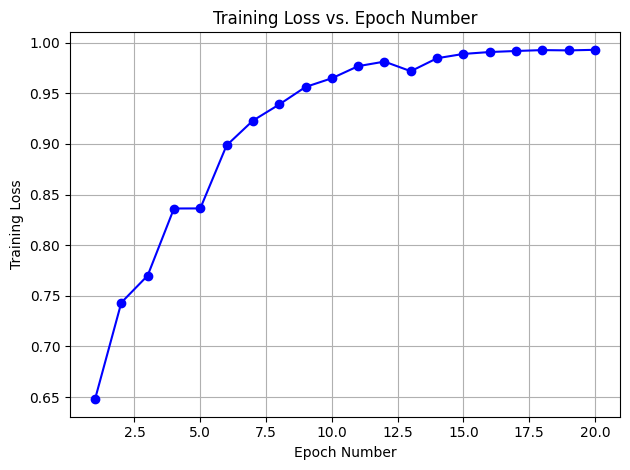

In [21]:
plotloss(final_train_f1_score,"Training")

In [22]:
print("validation f1 score",final_val_f1_score)

validation f1 score [0.6771410689733974, 0.7453509815924444, 0.7318856967124994, 0.7546954146887992, 0.723247690090794, 0.7461903069058008, 0.740410838973145, 0.7521867781965139, 0.7290859300651805, 0.747004346160104, 0.7457413802375666, 0.7520707673715089, 0.7199539452643121, 0.7376067302074546, 0.7315705875833555, 0.7474696871937067, 0.7528024732128578, 0.7388620195320591, 0.7356072805348167, 0.7365023868488937]


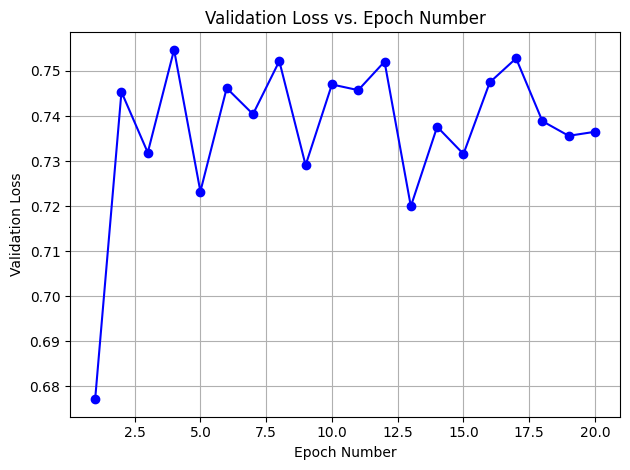

In [23]:
plotloss(final_val_f1_score,"Validation")

In [24]:
final_accuracy, macro_f1_score = evaluate_model(model, testLoader)

print("The accuracy of the model is:", final_accuracy)
print("The Macro-F1 score obtained is:", macro_f1_score)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 